데이터 확인

In [1]:
import konlpy
import pandas as pd
import numpy as np

# 트레인 데이터와 테스트 데이터 확인
df_train = pd.read_csv('./textmining3/ratings_train.txt', delimiter='\t', keep_default_na=False)
df_test = pd.read_csv('./textmining3/ratings_test.txt', delimiter='\t', keep_default_na=False)

print(df_train.head(n=5), '\n')
print(df_test.head(n=5))

C:\Users\john\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1 

        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


영화평 문자열과 평점label 확인하기

In [2]:
#학습 데이터의 문자열(document)과 평점 정보(label)를 각각 추출하여 크기 확인

text_train = df_train['document']
y_train = df_train['label']

text_test = df_test['document']
y_test = df_test['label']

#np.bincount: 각 bin의 요소를 센다. 즉, distinct counting
# 라벨만 추출한 것은 y_train, y_test의 0의 갯수, 1의 갯수를 추출하여 출력
print(len(text_train), np.bincount(y_train))
print(len(text_test), np.bincount(y_test))

150000 [75173 74827]
50000 [24827 25173]


Okt 사용하기 - 구 트위터

In [3]:
from konlpy.tag import Okt
okt = Okt()

# u는 유니코드 리터럴로 만들어준다는 것 뜻함.
print(okt.morphs(u'단독입찰보다 복수입찰의 경우'))
print(okt.nouns(u'유일하게 항공기 체계 종합개발 경험을 가지는 카이스트는'))
print(okt.phrases(u'스파이더맨 너무 좋아 아이언맨 사랑해요'))

print(okt.pos('이것도 되나욬ㅋㅋㅋㅋ'))
print(okt.pos('이것도 되나욬ㅋㅋㅋㅋ', norm=True))
print(okt.pos('이것도 되나욬ㅋㅋㅋㅋ', norm=True, stem=True))

['단독', '입찰', '보다', '복수', '입찰', '의', '경우']
['항공기', '체계', '종합', '개발', '경험', '카이스트']
['스파이더맨', '아이언맨', '아이언맨 사랑', '사랑']
[('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되나욬', 'Noun'), ('ㅋㅋㅋㅋ', 'KoreanParticle')]
[('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되나요', 'Verb'), ('ㅋㅋㅋ', 'KoreanParticle')]
[('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되다', 'Verb'), ('ㅋㅋㅋ', 'KoreanParticle')]


Okt 형태소 분석기 사용

In [4]:
# 형태소 분석기 객체 생성
from konlpy.tag import Okt
tag = Okt()

#Okt morphs를 사용한 토크나이저 함수
def okt_tokenizer(text):
    return tag.morphs(text)

# 토크나이저 개선: pos 태거의 노말라이제이션, 스테밍 활용
# 고침: return r의 인덴테이션이 잘못되면 전부 출력되는 게 아니라 일부만 출력된다.
def tokenizer_better(text):
    malist = tag.pos(text, norm=True, stem=True)
    r=[] #함수 돌릴 때마다 초기화해줘야 누적이 안 됨.
    for word in malist:
        if not word[1] in ["Josa", "Eomi", "Punctuation", "KoreanParticle"]:
            r.append(word[0])
    return r
    
print(okt_tokenizer(u'마블영화는 중학교 때부터 지금까지 재밌었다'))
print(tokenizer_better(u'마블 영화는 중학교 때부터 지금까지 재밌었다'))
print(tokenizer_better(u'아 진짜 웃곀ㅋㅋㅋㅋㅋ'))

['마블', '영화', '는', '중학교', '때', '부터', '지금', '까지', '재밌었다']
['마블', '영화', '중학교', '때', '지금', '재밌다']
['아', '진짜', '웃기다']


나이브 베이지안 분류기

In [5]:
import konlpy
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

from konlpy.tag import Okt
tag = Okt()

def okt_tokenizer(text):
    malist = tag.pos(text, norm=True, stem=True)
    r = []
    for word in malist:
        if not word[1] in ["Josa", "Eomi", "Punctuation", "KoreanParticle"]:
            r.append(word[0])
    return r
    
df_train = pd.read_csv('./textmining3/ratings_train.txt', delimiter='\t', keep_default_na=False)
df_test = pd.read_csv('./textmining3/ratings_test.txt', delimiter='\t', keep_default_na=False)

멀티노미알 나이브 베이지안 사용. 실행 시간이 오래 걸림. 텍스트는 특징수 많아서 줄이려는 노력이 필요(차원축소/특징선택 등)

In [7]:
# 학습 데이터의 문자열document와 평점 정보label을 각각 추출

text_train = df_train['document']
y_train = df_train['label']

text_test = df_test['document']
y_test = df_test['label']

vect = CountVectorizer(tokenizer=okt_tokenizer).fit(text_train)

x_train = vect.transform(text_train)
clf_mult = MultinomialNB().fit(x_train, y_train)

x_test = vect.transform(text_test)

#데이터 예측하기
pre = clf_mult.predict(x_test)

#정답률 산출
ac_score = metrics.accuracy_score(y_test, pre)
print("정답률 = ", ac_score)

정답률 =  0.8402


워드 클라우드

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = open('./textmining3/speech.txt', encoding='ISO8859').read()

#자동으로 텍스트의 term을 추출하여 상대적인 출현 빈도수를 개선하고 어레이 형태로 이미지를 생성
wordcloud = WordCloud().generate(text)
print(type(wordcloud))

#워드클라우드.워즈_에 'dict' 타입으로 빈도수 저장
print(type(wordcloud.words_))
print(wordcloud.words_)

<class 'wordcloud.wordcloud.WordCloud'>
<class 'dict'>
{'us': 1.0, 'will': 0.782608695652174, 'nation': 0.6521739130434783, 'new': 0.4782608695652174, 'America': 0.43478260869565216, 'every': 0.34782608695652173, 'people': 0.34782608695652173, 'must': 0.34782608695652173, 'generation': 0.34782608695652173, 'less': 0.30434782608695654, 'work': 0.30434782608695654, 'world': 0.30434782608695654, 'let': 0.30434782608695654, 'today': 0.2608695652173913, 'now': 0.2608695652173913, 'time': 0.2608695652173913, 'common': 0.2608695652173913, 'day': 0.21739130434782608, 'know': 0.21739130434782608, 'spirit': 0.21739130434782608, 'God': 0.21739130434782608, 'seek': 0.21739130434782608, 'American': 0.21739130434782608, 'words': 0.17391304347826086, 'peace': 0.17391304347826086, 'crisis': 0.17391304347826086, 'far': 0.17391304347826086, 'hard': 0.17391304347826086, 'come': 0.17391304347826086, 'end': 0.17391304347826086, 'long': 0.17391304347826086, 'things': 0.17391304347826086, 'greater': 0.173913

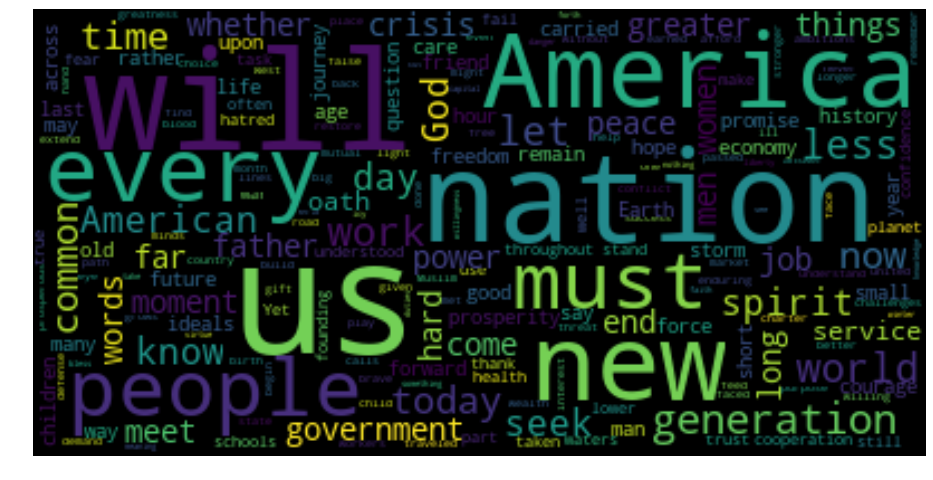

In [9]:
# 이미지 생성
wordcloud = WordCloud(max_font_size=70).generate(text)

#피겨 사이즈 설정
plt.figure(figsize=(16,9))

#plt.imshow: nparray를 이미지로 표현하는 방법.
#인터폴레이션: 픽셀간 경계를 얼마나 부드럽게 하는가?
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

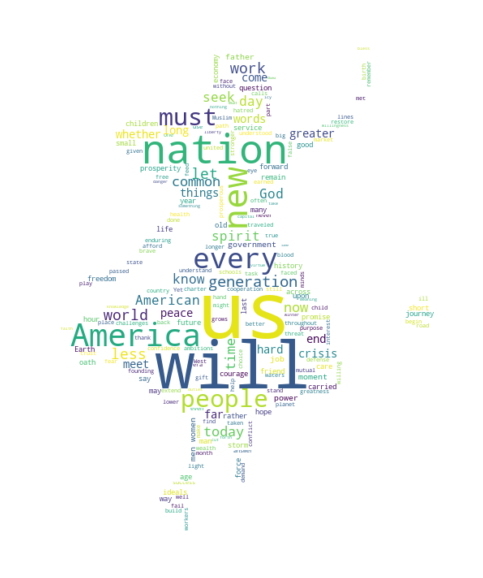

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

text = open('./textmining3/speech.txt', encoding='ISO8859').read()

#그림 모양 나타내는 이미지 생성
alice_mask = np.array(Image.open('./textmining3/alice.jpg'))

#배경이미지, 불용어 지정
wc = WordCloud(background_color='white', max_words=200, mask=alice_mask, stopwords=STOPWORDS)
wc.generate(text)

#보이기
plt.figure(figsize=(10,10)) #인치 단위 이미지 크기 지정
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

plt.show()

한글 워드클라우드 예제

<class 'list'>
{'국민': 18, '우리': 17, '것': 14, '수': 11, '새해': 6, '해': 6, '대한민국': 6, '더': 6, '정부': 6, '평화': 6, '일': 5, '작년': 4, '저': 4, '모든': 4, '나라': 4, '대화': 4, '노력': 4, '북한': 4, '여러분': 3, '대표': 3, '분': 3, '해결': 3, '지난해': 3, '혁명': 3, '세계': 3, '위': 3, '대통령': 3, '최선': 3, '뜻': 3, '사회': 3, '평창올림픽': 3, '비롯': 2, '감사': 2, '또': 2, '환영': 2, '박수': 2, '촛불': 2, '국가': 2, '정상': 2, '회담': 2, '때': 2, '수출': 2, '여러': 2, '가지': 2, '지난': 2, '내': 2, '올해': 2, '해소': 2, '경쟁': 2, '기원': 2, '삶': 2, '소망': 2, '하나': 2, '한반도': 2, '남북': 2, '안전': 2, '무술년': 2, '복': 1, '오늘': 1, '부요': 1, '각계': 1, '각층': 1, '원로': 1, '또한': 1, '기억': 1, '수능': 1, '지진': 1, '때문': 1, '어려움': 1, '포항': 1, '여고': 1, '학생': 1, '정규직': 1, '꿈': 1, '비정규직': 1, '노동자': 1, '장기': 1, '미제': 1, '사건': 1, '경찰관': 1}


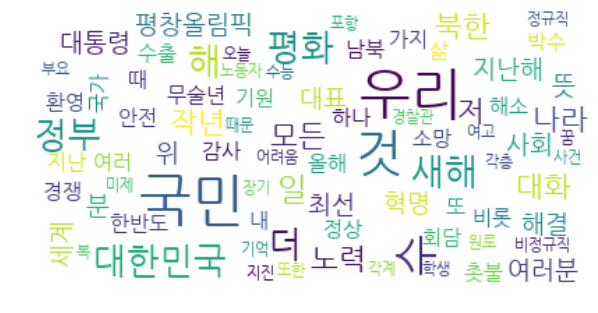

In [11]:
import konlpy
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

text = open('./textmining3/moon.txt', encoding='utf-8').read()

t=Okt()
tokens=t.nouns(text) #명사 추출
count=Counter(tokens) #추출된 명사의 빈도수 계산
tags=count.most_common(80) #빈도수 높은 순서로 80개만 추출

print(type(tags))

dict_tags = dict(tags) #dict 타입으로 변환
print(dict_tags)

#이미지 생성 / 한글폰트 지정 필요 / 빈도수는 이미 계산한 상태
wc = WordCloud(font_path='./NanumGothic.ttf',
              background_color='white',
              max_font_size=40,
            ).generate_from_frequencies(dict_tags)

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

한글예제 2           ????????????? 왜 짤리는거야???????????????????

<class 'list'>
{'국민': 18, '우리': 17, '것': 14, '수': 11, '새해': 6, '해': 6, '대한민국': 6, '더': 6, '정부': 6, '평화': 6, '일': 5, '작년': 4, '저': 4, '모든': 4, '나라': 4, '대화': 4, '노력': 4, '북한': 4, '여러분': 3, '대표': 3, '분': 3, '해결': 3, '지난해': 3, '혁명': 3, '세계': 3, '위': 3, '대통령': 3, '최선': 3, '뜻': 3, '사회': 3, '평창올림픽': 3, '비롯': 2, '감사': 2, '또': 2, '환영': 2, '박수': 2, '촛불': 2, '국가': 2, '정상': 2, '회담': 2, '때': 2, '수출': 2, '여러': 2, '가지': 2, '지난': 2, '내': 2, '올해': 2, '해소': 2, '경쟁': 2, '기원': 2, '삶': 2, '소망': 2, '하나': 2, '한반도': 2, '남북': 2, '안전': 2, '무술년': 2, '복': 1, '오늘': 1, '부요': 1, '각계': 1, '각층': 1, '원로': 1, '또한': 1, '기억': 1, '수능': 1, '지진': 1, '때문': 1, '어려움': 1, '포항': 1, '여고': 1, '학생': 1, '정규직': 1, '꿈': 1, '비정규직': 1, '노동자': 1, '장기': 1, '미제': 1, '사건': 1, '경찰관': 1}


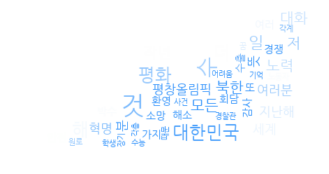

In [14]:
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import ImageColorGenerator
from PIL import Image
import numpy as np

txt = open('./textmining3/moon.txt', encoding='utf-8').read()

kor = np.array(Image.open('./textmining3/korea_mask.jpg'))
colors = ImageColorGenerator(kor) #코리아마스크 이미지 내 컬러만 사용

t=Okt()
tokens=t.nouns(txt)
count=Counter(tokens) 
tags=count.most_common(80) 

print(type(tags))

dict_tags = dict(tags) #dict 타입으로 변환
print(dict_tags)

#이미지 생성 / 한글폰트 지정 필요 / 빈도수는 이미 계산한 상태
wc = WordCloud(font_path='./NanumGothic.ttf',
              background_color='white',
              max_font_size=40,
               color_func =colors
            ).generate_from_frequencies(dict_tags)

plt.figure(figsize=(5,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()